In this notebook, we will first train a flower classification model using transfer learning. We will be using the pre-trained weights of a MobileNetV2. We will then launch a targeted attack on the trained model. Note that the purpose of this notebook is to show a workflow and not to train a SoTA model. 

## Initial setup

In [2]:
# TensorFlow version
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
# Which GPU?
!nvidia-smi

Fri Oct 23 05:58:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
# Other imports
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import time
import cv2
import os

# Fix the seeds
SEED = 666
tf.random.set_seed(SEED)
np.random.seed(SEED)

## Dataset collection and preparation

In [5]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

# Specify the class labels, we would need this to create targeted attacks
CLASSES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


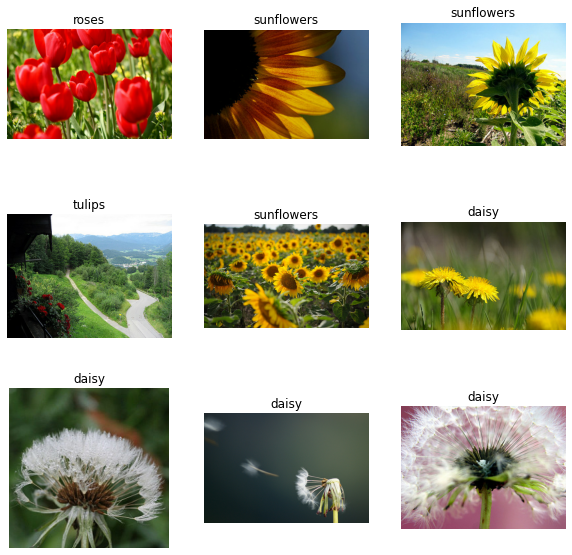

In [6]:
# Visualization
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASSES[int(label)])
    plt.axis("off")

In [7]:
# Image preprocessing utils

SIZE = (224, 224)

def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, SIZE)
    return (image, label)

In [8]:
# Construct TensorFlow dataset
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE

train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .cache()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

## Model training utils

In [9]:
def get_training_model(base_model):
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(5, activation="softmax")(x)
    classifier = Model(inputs=inputs, outputs=x)
    
    return classifier

def plot_progress(hist):
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="validation_loss")
    plt.plot(hist.history["accuracy"], label="training_accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation_accuracy")
    plt.title("Training Progress")
    plt.ylabel("accuracy/loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.show()

In [21]:
# Load the MobileNetV2 model but exclude the classification layers
mn = MobileNetV2(weights="imagenet", include_top=False)
mn.trainable = False 
get_training_model(mn).summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Model building

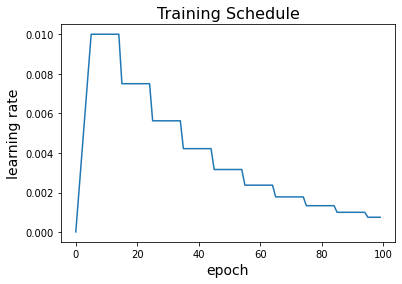

In [22]:
# CUSTOM LEARNING SCHEUDLE
# Reference: https://www.kaggle.com/cdeotte/how-to-compete-with-gpus-workshop
LR_START = 1e-5
LR_MAX = 1e-2
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.75

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//10)
    return lr
    
lr2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(100)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Training Schedule',size=16); plt.show()

In [23]:
# Early stopping callback
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30
49/49 [==============================] - 5s 108ms/step - loss: 1.7271 - accuracy: 0.2292 - val_loss: 1.6579 - val_accuracy: 0.2691

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0020080000000000002.
Epoch 2/30
49/49 [==============================] - 4s 91ms/step - loss: 0.6877 - accuracy: 0.7449 - val_loss: 0.3903 - val_accuracy: 0.8655

Epoch 00003: LearningRateScheduler reducing learning rate to 0.004006.
Epoch 3/30
49/49 [==============================] - 5s 92ms/step - loss: 0.3676 - accuracy: 0.8785 - val_loss: 0.3539 - val_accuracy: 0.8855

Epoch 00004: LearningRateScheduler reducing learning rate to 0.006004000000000001.
Epoch 4/30
49/49 [==============================] - 4s 92ms/step - loss: 0.2805 - accuracy: 0.9093 - val_loss: 0.2829 - val_accuracy: 0.9036

Epoch 00005: LearningRateScheduler reducing learning rate to 0.008002.
Epoch 5/30
49/49 [==============================] - 4

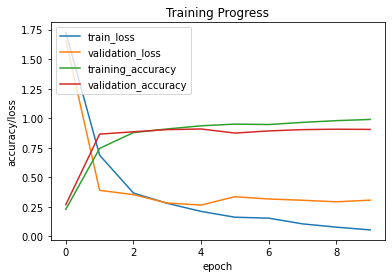

In [24]:
# Train the model
model_mn = get_training_model(mn)
model_mn.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
start = time.time()
h = model_mn.fit(train_ds,
              validation_data=validation_ds,
              epochs=30,
              callbacks=[lr2, es])
print("Total training time (seconds): ",time.time()-start)
plot_progress(h)

## Plotting sample predictions

In [27]:
# Utility to plot sample predictions 
def plot_predictions(images, labels, probability):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image.numpy())
        predicted_label = CLASSES[np.argmax(probability[i])]
        maximum_probability = "{:.3f}".format(max(probability[i]))
        text = "{} with probability: {}".format(predicted_label, maximum_probability) + \
            "\nGround-truth: {}".format(CLASSES[int(labels[i])])
        plt.title(text)
        plt.axis("off")
    plt.show()

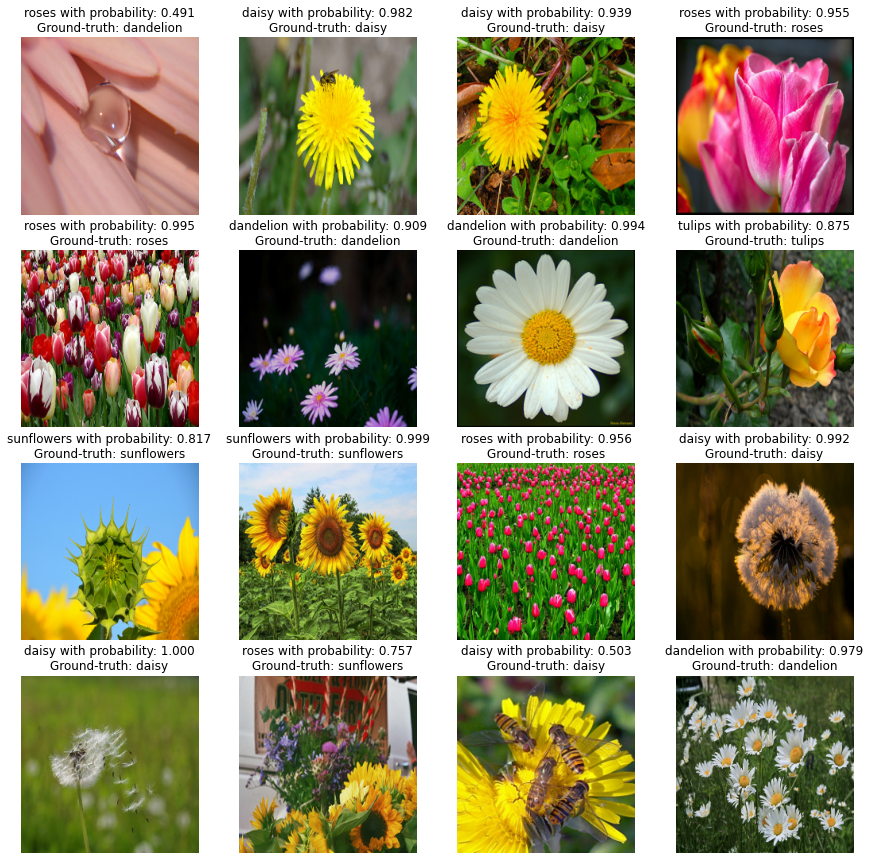

In [28]:
# Let's run inference on a batch of images from the validation set
(batch_images, batch_labels) = next(iter(validation_ds))
predictions = model_mn.predict(batch_images)
plot_predictions(batch_images[:16], batch_labels[:16], predictions[:16])

## Utilities for creating a targeted adversarial example

In [29]:
#@title
EPS = 2./255

def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, clip_value_min=-EPS, clip_value_max=EPS)

In [40]:
#@title
def generate_adversaries_targeted(model, image_tensor, delta, 
    true_index, target_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

    for t in range(350):
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = (image_tensor + delta)/255.
            predictions = model(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) + 
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions))
            if t % 20 == 0:
                print(t, loss.numpy())
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Clip so that the delta values are within [0,1]
        delta.assign_add(clip_eps(delta))

    return delta

In [41]:
#@title
def perturb_image(model, image, true, target):
    print("Before adversarial attack")
    preprocessed_image = image/255.
    probabilities = model.predict(preprocessed_image)
    class_index = np.argmax(probabilities)
    print("Ground-truth label: {} predicted label: {}".format(CLASSES[true], CLASSES[class_index]))
    
    # Initialize the perturbation quantity
    image_tensor = tf.constant(image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the adversary vector
    delta_tensor = generate_adversaries_targeted(model, image_tensor, delta, true, target)

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = (image_tensor + delta_tensor)/255.
    print("After adversarial attack")
    
    # Generate predictions
    preds = model.predict(perturbed_image)[0]
    i = np.argmax(preds)
    pred_label = CLASSES[i]

    print("Predicted label: {}".format(pred_label))
    cv2.imwrite("perturbed_image.png", perturbed_image.numpy().squeeze())


## Launching the attack

Turning a dandelion (class index 0) (last image from the figure above) to a tulip (class index 4).

Before adversarial attack
Ground-truth label: dandelion predicted label: dandelion
0 7.9549375
20 5.6687813
40 4.061853
60 2.7291937
80 1.5011871
100 0.41923833
120 -0.5752425
140 -1.5147665
160 -2.5183306
180 -3.5228558
200 -4.6065702
220 -5.644107
240 -6.662843
260 -7.702099
280 -8.854189
300 -10.093956
320 -11.418548
340 -12.7528305


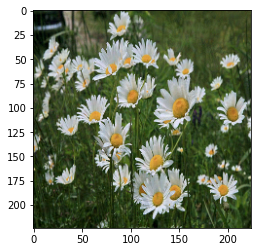

After adversarial attack
Predicted label: tulips


In [42]:
# Let's see this in action
index = 15
sample_val_image = (batch_images[index].numpy()*255).astype(np.uint8)
sample_val_image = np.expand_dims(sample_val_image, 0)
perturb_image(model_mn, sample_val_image, batch_labels[index].numpy(), 4)